In [70]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain_experimental python-dotenv matplotlib numpy pandas langgraph

## Ejecución de codigo usando exec

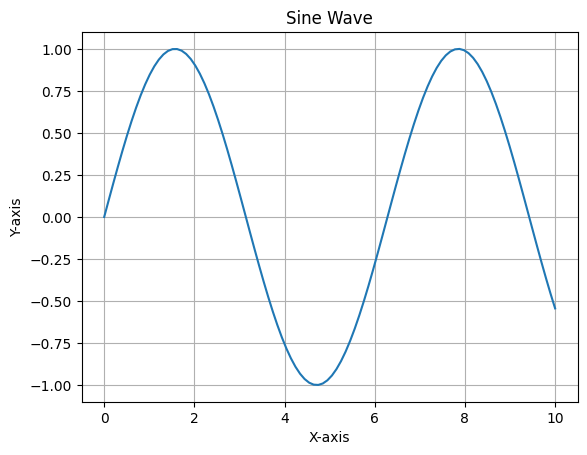

In [71]:
class ChartPythonREPL:
    def run(self, code: str):
        try:
            exec(code, globals())
        except Exception as e:
            print(f"Error: {e}")

# Create an instance of the extended REPL
chart_repl = ChartPythonREPL()

# Example code to generate a chart
chart_code = """
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a plot
plt.figure()
plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
"""

# Run the chart generation code
chart_repl.run(chart_code)

## Ejecución de codigo usando PythonREPL

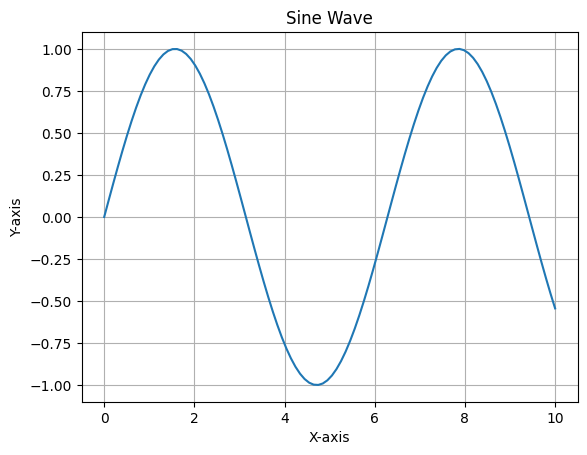

In [72]:
from langchain_experimental.utilities import PythonREPL

# Create an instance of the PythonREPL
python_repl = PythonREPL()

# Example code to generate a chart
chart_code = """
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a plot
plt.figure()
plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
"""

# Run the chart generation code using the PythonREPL instance
output = python_repl.run(chart_code)

## Ejecución usando REPL y retornando el resultado en base64

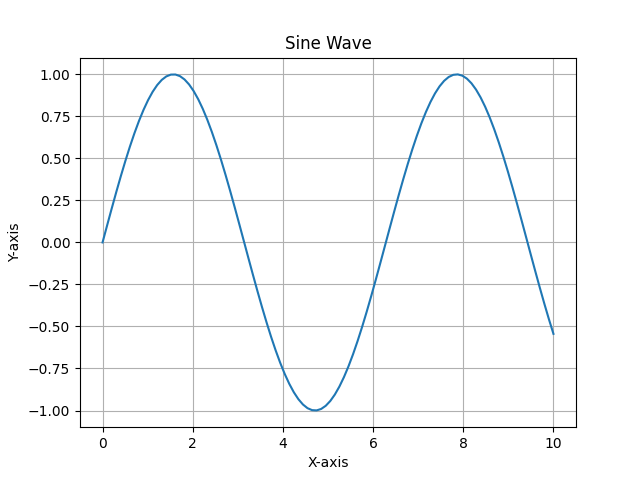

In [73]:
import base64
from langchain_experimental.utilities import PythonREPL

# Example code to generate a chart and capture the output
chart_code = """
import matplotlib.pyplot as plt
import numpy as np
import io
import base64

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a plot
plt.figure()
plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)

# Save the plot to a buffer
buffer = io.BytesIO()
plt.savefig(buffer, format='png')
plt.close()

# Seek to the beginning of the buffer
buffer.seek(0)

# Encode the buffer as a base64 string
img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')

# Print the base64 string
print(img_str)
"""

# Create an instance of the PythonREPL
python_repl = PythonREPL()

# Run the chart generation code using the PythonREPL instance
output = python_repl.run(chart_code)

# Decode and display the image
from IPython.display import Image, display
img_data = base64.b64decode(output.strip())
display(Image(data=img_data))

## Creación de una Tool para la executar codigo en Python

La idea seria, tener un agente que se encargue de la generación del codigo,
que utilice la Tool para ejecutar y obtener el resultado en base64, y luego
poder mostrar el resultado en un notebook.

In [20]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [21]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## Testeamos que el modelo funcione
output = llm.invoke("Hello, how are you?")

output.content

"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [46]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import base64

@tool
def exec_python(code: str) -> str:
    """
    Executes the provided Python code in a REPL (Read-Eval-Print Loop) environment and returns the output.

    This function runs the given code string in an isolated Python REPL environment and captures its output.
    
    Technical limitations:
        1. The output of any program MUST finish with a `print(return_value)` call. If this condition is not met, the execution will fail.
        2. If the `return_value` is binary (e.g., an image in PNG format), it should be encoded in base64. For instance, instead of plotting an image directly, use a buffer to capture the image and encode it in base64 before assigning it to `return_value`.

    Args:
        code: The Python code to be executed.

    Returns:
        str: The captured output from the code execution.

    Example:
        >>> code = '''
        ... result = 3 + 4
        ... print(result)
        ... '''
        >>> output = exec_python(code)
        >>> print(output)
        7
    """
    python_repl = PythonREPL()

    try:
        output = python_repl.run(code)
    except Exception as e:
        print(f"An error occurred: {e}")

    # Eliminamos caractares de escape y retornamos el output
    return output.strip()

@tool
def is_base64(s: str) -> bool:
    """
    Checks if a string is a valid base64 string.
    
    Args:
        s: The string to check.
    
    Returns:
        bool: True if the string is a valid base64 string, False otherwise.
    """
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False

@tool
def display_base64(base64_str: str):
    """
    Converts a base64 string to an image and displays it.
    
    Args:
        base64_str: The base64 string representing the image.
    """
    img_data = base64.b64decode(base64_str.strip())
    display(Image(data=img_data))

In [42]:
from langchain_core.messages import HumanMessage, SystemMessage

tools = [exec_python, is_base64, display_base64]

agent_def="""
You are a Software Engineer. 
Plenty experience in Python, Java, and C++.

Stategies to solve problems:
- Use your skills of manager and engineer to solve the problem
- Divide and conquer using the available tools

Always answer to the user with the results.
"""

agent_prompt = SystemMessage(content=agent_def)
human_prompt = HumanMessage(content="describe shortly your available tools")

output = llm.bind_tools(tools, parallel_tool_calls=False).invoke([agent_prompt] + [human_prompt])

print(output.content)

I have access to the following tools:

1. **Python Execution**: I can execute Python code in a REPL environment. The code must end with a `print(return_value)` call to return the output.

2. **Base64 Validation**: I can check if a given string is a valid base64 encoded string.

3. **Base64 Image Display**: I can convert a base64 string representing an image and display it.

These tools enable me to perform computations, data validation, and image handling effectively.


In [43]:
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

code = """
return_value = 3 + 4
print(return_value)
"""

message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "exec_python",
            "args": {"code": code },
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='7', name='exec_python', tool_call_id='tool_call_id')]}

In [49]:
human_prompt = HumanMessage(content="""
3 + 4
""")

output = llm.bind_tools(tools, parallel_tool_calls=False).invoke([agent_prompt] + [human_prompt])

print(f"Full output: {output}")

# Extract the result from the tool call response
if 'tool_calls' in output.additional_kwargs:
    for tool_call in output.additional_kwargs['tool_calls']:
        if tool_call['function']['name'] == 'exec_python':
            # Assuming the result is in the 'content' field of the tool call response
            result = tool_call['function']['arguments']
            print(f"Result: {result}")
else:
    print("No tool calls found in the output.")

Full output: content='' additional_kwargs={'tool_calls': [{'id': 'call_MU6xBgy4boYfAxVoF2ZPdXEc', 'function': {'arguments': '{"code":"result = 3 + 4\\nprint(result)"}', 'name': 'exec_python'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 395, 'total_tokens': 419, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5fd786ed-aea6-43c4-9947-b091b7c44554-0' tool_calls=[{'name': 'exec_python', 'args': {'code': 'result = 3 + 4\nprint(result)'}, 'id': 'call_MU6xBgy4boYfAxVoF2ZPdXEc', 'type': 'tool_call'}] usage_metadata={'input_tokens': 395, 'output_tokens': 24, 'total_tokens': 419, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}
Result: {"code":"result = 3 + 4\

## Generación del grafo que conecta todo

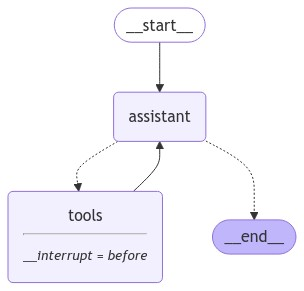

In [61]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage

from langgraph.checkpoint.memory import MemorySaver

class OverallState(MessagesState):
    code_output: str

def assistant(state: OverallState):
    response = llm.bind_tools(tools, parallel_tool_calls=False).invoke([agent_prompt] + state["messages"])
    return { "messages": response }

# Graph
builder = StateGraph(OverallState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [62]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = graph.invoke({"messages": messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  exec_python (call_kBVNHDT4hInWU9Z5CSUo9zhk)
 Call ID: call_kBVNHDT4hInWU9Z5CSUo9zhk
  Args:
    code: result = (3 + 4) * 2 / 5
print(result)


In [64]:
_state = graph.get_state(config=config)

print(f"State: {_state}")

State: StateSnapshot(values={'messages': [HumanMessage(content='Add 3 and 4. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='1cfaeabf-50b4-4380-9962-9400acebca3d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kBVNHDT4hInWU9Z5CSUo9zhk', 'function': {'arguments': '{"code":"result = (3 + 4) * 2 / 5\\nprint(result)"}', 'name': 'exec_python'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 409, 'total_tokens': 440, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-668c00fe-06b6-46f6-9231-570f9cce5b3b-0', tool_calls=[{'name': 'exec_python', 'args': {'code': 'result = (3 + 4) * 2 / 5\nprint(result)'}, 'id': 'call_kBVNHDT

In [65]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  exec_python (call_kBVNHDT4hInWU9Z5CSUo9zhk)
 Call ID: call_kBVNHDT4hInWU9Z5CSUo9zhk
  Args:
    code: result = (3 + 4) * 2 / 5
print(result)
================================= Tool Message =================================
Name: exec_python

2.8
================================== Ai Message ==================================

The result of the calculations is **2.8**.


In [66]:
messages = [HumanMessage(content="Plot y = 0 and display the plot.")]
messages = graph.invoke({"messages": messages}, debug=True, config=config)

for m in messages['messages']:
    m.pretty_print()

[4:checkpoint] State at the end of step 4:
{'messages': [HumanMessage(content='Add 3 and 4. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='1cfaeabf-50b4-4380-9962-9400acebca3d'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kBVNHDT4hInWU9Z5CSUo9zhk', 'function': {'arguments': '{"code":"result = (3 + 4) * 2 / 5\\nprint(result)"}', 'name': 'exec_python'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 409, 'total_tokens': 440, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-668c00fe-06b6-46f6-9231-570f9cce5b3b-0', tool_calls=[{'name': 'exec_python', 'args': {'code': 'result = (3 + 4) * 2 / 5\nprint(r

In [68]:
_state = graph.get_state(config=config)

_state.next

('tools',)

================================== Ai Message ==================================
Tool Calls:
  exec_python (call_YyeO64BFfzpP0AS5K4yRkJB9)
 Call ID: call_YyeO64BFfzpP0AS5K4yRkJB9
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)
y = np.zeros_like(x)

plt.plot(x, y, label='y = 0')
plt.title('Plot of y = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

import io
import base64

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode('utf-8')
print(img_base64)
================================= Tool Message =================================
Name: exec_python

iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAB

KeyboardInterrupt: 

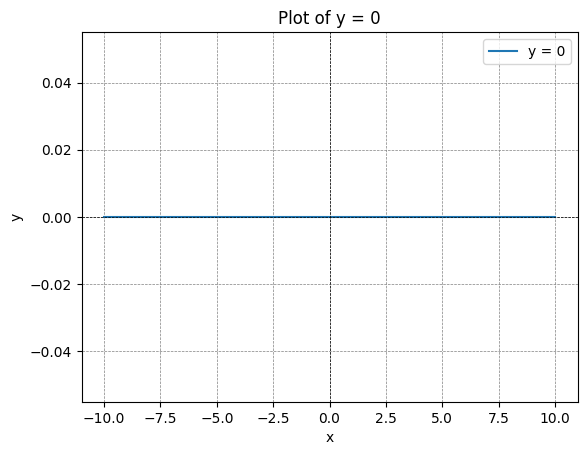

In [69]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [70]:
_state = graph.get_state(config=config)

_state.next

('assistant',)